Notebook made by: **Kirdin Matvei**, 

e-mail: mdkirdin@student.hse.ru

In [1]:
import collections
import random
import re
import string
import time
import math

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torchsummary import summary
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

tqdm.pandas()

Fix the random generator for the purpose of reproducability.

In [6]:
random_seed = 12
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


# Question 1.

**Build and Train a Simple Neural Network.**

* Create a basic neural network from scratch using Python and a library of your choice (e.g., TensorFlow, PyTorch, or Keras).
* Explain the importance of layers, activation functions, and a training loop for backpropagation and Gradient descent.
* Document your code, explain each layer's purpose, and discuss the network's performance. You can use any dataset for explaining.

In this example I will use the ```Fashion MNIST``` dataset, as it is readily available and comes with PyTorch. It contains 28x28 images of clothing, which are to be classified into 10 categories: 
* T-shirt/top $-$ 0,
* Trouser $-$ 1,
* Pullover $-$ 2,
* Dress $-$ 3,
* Coat $-$ 4,
* Sandal $-$ 5,
* Shirt $-$ 6,
* Sneaker $-$ 7,
* Bag $-$ 8,
* Ankle boot $-$ 9.

In [7]:
training_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Create data loaders and slice data up into batches of 64 instances on which the gradient is to be computed.

In [8]:
train_batch_size = 128
test_batch_size = 1024

train_dataloader = DataLoader(training_data, batch_size=train_batch_size)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Number of train batches: {len(train_dataloader)}")
    print(f"Number of test batches: {len(test_dataloader)}")
    break

Shape of X [N, C, H, W]: torch.Size([1024, 1, 28, 28])
Shape of y: torch.Size([1024]) torch.int64
Number of train batches: 469
Number of test batches: 10


In this example I decided to use ReLU activation function to prevent the issue of vanishing gradients during the backpropogation. This network consists of 3 layers:

* Pooling layer, that downsizes the data to be 512-dimensional.
* Dense (fully connected) layer.
* Output layer.

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Transform 28*28 images into flat 1*784 arrays
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Let's create the network object and display its overall structure:

In [10]:
model = NeuralNetwork()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


Here we use cross-entropy loss function and do the backpropogation with stochastic gradient descend.

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error:\n  Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )
    return correct

In [14]:
epochs = 5
test_acc1 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_acc1 += [test(test_dataloader, model, loss_fn)]
print("Done!")

Epoch 1
-------------------------------
loss: 2.304436  [  128/60000]
loss: 2.288648  [12928/60000]
loss: 2.270493  [25728/60000]
loss: 2.255106  [38528/60000]
loss: 2.244851  [51328/60000]
Test Error:
  Accuracy: 36.5%, Avg loss: 2.231294 

Epoch 2
-------------------------------
loss: 2.236107  [  128/60000]
loss: 2.212313  [12928/60000]
loss: 2.196492  [25728/60000]
loss: 2.182191  [38528/60000]
loss: 2.166003  [51328/60000]
Test Error:
  Accuracy: 47.1%, Avg loss: 2.148890 

Epoch 3
-------------------------------
loss: 2.154203  [  128/60000]
loss: 2.118073  [12928/60000]
loss: 2.098394  [25728/60000]
loss: 2.078293  [38528/60000]
loss: 2.054468  [51328/60000]
Test Error:
  Accuracy: 53.4%, Avg loss: 2.029860 

Epoch 4
-------------------------------
loss: 2.032896  [  128/60000]
loss: 1.980168  [12928/60000]
loss: 1.955227  [25728/60000]
loss: 1.923157  [38528/60000]
loss: 1.895604  [51328/60000]
Test Error:
  Accuracy: 55.2%, Avg loss: 1.862541 

Epoch 5
------------------------

# Question 2.

**Implement Dynamic Routing in a Capsule Network.**

* Design a small capsule network with dynamic routing to classify images from the CIFAR-10 or MNIST dataset.
* Implement dynamic routing between the primary and digit capsules.
* Explain the difference in performance when using dynamic routing versus traditional layers.

For this task, I will use ```FashionMNIST``` dataset as well.

Let's define the squash function, which will be used in dynamic routing instead of ReLU

In [12]:
def squash(s):
    lengths2 = s.pow(2).sum(dim=2)
    lengths = lengths2.sqrt()
    s = s * (lengths2 / (1 + lengths2**2) / lengths).view(s.size(0), s.size(1), 1)
    return s

Then, we can define the dynamic algorythm itself. It takes in the number of capsules in previous layer and in current layer, as well as the number of iterations of routing process. Coefficients b_ij are initialized as zeroes. 

In [13]:
class Routing(nn.Module):
    def __init__(self, input_caps, output_caps, n_iterations):
        super(Routing, self).__init__()
        self.n_iterations = n_iterations
        self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))

    def forward(self, u_predict):
        batch_size, input_caps, output_caps, output_dim = u_predict.size()

        c = nn.functional.softmax(self.b, dim=1)
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = squash(s)

        if self.n_iterations > 0:
            b_batch = self.b.expand((batch_size, input_caps, output_caps))
            for r in range(self.n_iterations):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = nn.functional.softmax(b_batch.view(-1, output_caps), 1).view(
                    -1, input_caps, output_caps, 1
                )
                s = (c * u_predict).sum(dim=1)
                v = squash(s)

        return v

Here, we define primary and digit capsule layers. All layers containing capsules(except for the first one) will be of digit layers. We randomly initialize weights for each capsule in digit layer, and do all the neccessary calculations on their output.

In [14]:
class PrimaryCapsLayer(nn.Module):
    def __init__(self, input_channels, output_caps, output_dim, kernel_size, stride):
        super(PrimaryCapsLayer, self).__init__()
        self.conv = nn.Conv2d(
            input_channels,
            output_caps * output_dim,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.input_channels = input_channels
        self.output_caps = output_caps
        self.output_dim = output_dim

    def forward(self, input):
        out = self.conv(input)
        N, C, H, W = out.size()
        out = out.view(N, self.output_caps, self.output_dim, H, W)

        # will output N x OUT_CAPS x OUT_DIM
        out = out.permute(0, 1, 3, 4, 2).contiguous()
        out = out.view(out.size(0), -1, out.size(4))
        out = squash(out)
        return out

In [15]:
class DigitCapsLayer(nn.Module):
    def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
        super(DigitCapsLayer, self).__init__()
        self.input_dim = input_dim
        self.input_caps = input_caps
        self.output_dim = output_dim
        self.output_caps = output_caps
        self.weights = nn.Parameter(
            torch.Tensor(input_caps, input_dim, output_caps * output_dim)
        )
        self.routing_module = routing_module
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.input_caps)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(
            u_predict.size(0), self.input_caps, self.output_caps, self.output_dim
        )
        v = self.routing_module(u_predict)
        return v

The CNN itself consists of a convolutional and pooling layers to cut down on calculational costs and capsule layers after that.

In [16]:
class CapsuleNetwork(nn.Module):
    def __init__(self, routing_iterations, n_classes=10):
        super(CapsuleNetwork, self).__init__()
        self.num_primaryCaps = 32 * 6 * 6
        routing_module = Routing(self.num_primaryCaps, n_classes, routing_iterations)
        self.CNN_stack = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            PrimaryCapsLayer(256, 32, 8, kernel_size=3, stride=2),  # outputs 6*6
            DigitCapsLayer(self.num_primaryCaps, 8, n_classes, 16, routing_module),
        )

    def forward(self, x):
        x = self.CNN_stack(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs

In [17]:
model = CapsuleNetwork(3)

In [18]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 26, 26]           2,560
              ReLU-2          [-1, 256, 26, 26]               0
         MaxPool2d-3          [-1, 256, 13, 13]               0
            Conv2d-4            [-1, 256, 6, 6]         590,080
  PrimaryCapsLayer-5              [-1, 1152, 8]               0
           Routing-6               [-1, 10, 16]               0
    DigitCapsLayer-7               [-1, 10, 16]               0
Total params: 592,640
Trainable params: 592,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 3.11
Params size (MB): 2.26
Estimated Total Size (MB): 5.38
----------------------------------------------------------------


Let's define loss for this model as it was defined in the original paper.

In [19]:
class MarginLoss(nn.Module):
    def __init__(self, m_pos, m_neg, lambda_):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, lengths, targets):
        t = torch.zeros(lengths.size()).long()
        t = t.scatter_(1, targets.data.view(-1, 1), 1)
        targets = torch.autograd.Variable(t)
        losses = targets.float() * nn.functional.relu(self.m_pos - lengths).pow(
            2
        ) + self.lambda_ * (1.0 - targets.float()) * nn.functional.relu(
            lengths - self.m_neg
        ).pow(
            2
        )
        return losses.sum()

In [20]:
loss_fn = MarginLoss(0.9, 0.1, 0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X, y = torch.autograd.Variable(X), torch.autograd.Variable(
            y, requires_grad=False
        )
        optimizer.zero_grad()

        # Compute prediction error
        output, probs = model(X)
        loss = loss_fn(probs, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.data, (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = torch.autograd.Variable(X), torch.autograd.Variable(y)
            output, probs = model(X)
            test_loss += loss_fn(probs, y)
            correct += (probs.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"\nTesting:\n  Accuracy: {100.0 * correct:>0.1f}%, Avg loss: {test_loss:>4f}\n"
    )
    return correct

In [23]:
epochs = 5
test_acc2 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_acc2 += [test(test_dataloader, model, loss_fn)]
print("Done!")

Epoch 1
-------------------------------
loss: 103.111916  [  128/60000]
loss: 28.666084  [12928/60000]
loss: 27.120028  [25728/60000]
loss: 26.818317  [38528/60000]
loss: 27.644203  [51328/60000]

Testing:
  Accuracy: 87.5%, Avg loss: 214.574127

Epoch 2
-------------------------------
loss: 25.551641  [  128/60000]
loss: 25.506222  [12928/60000]
loss: 25.551483  [25728/60000]
loss: 24.966291  [38528/60000]
loss: 26.088415  [51328/60000]

Testing:
  Accuracy: 89.7%, Avg loss: 210.610474

Epoch 3
-------------------------------
loss: 25.054024  [  128/60000]
loss: 24.486589  [12928/60000]
loss: 24.991865  [25728/60000]
loss: 24.465712  [38528/60000]
loss: 25.133774  [51328/60000]

Testing:
  Accuracy: 90.3%, Avg loss: 206.851883

Epoch 4
-------------------------------
loss: 24.518568  [  128/60000]
loss: 23.979134  [12928/60000]
loss: 24.666954  [25728/60000]
loss: 23.998575  [38528/60000]
loss: 24.325760  [51328/60000]

Testing:
  Accuracy: 90.9%, Avg loss: 204.323059

Epoch 5
-------

Let's compare performances of a regular neural network and CNN in terms of accuracy achieved in testing.

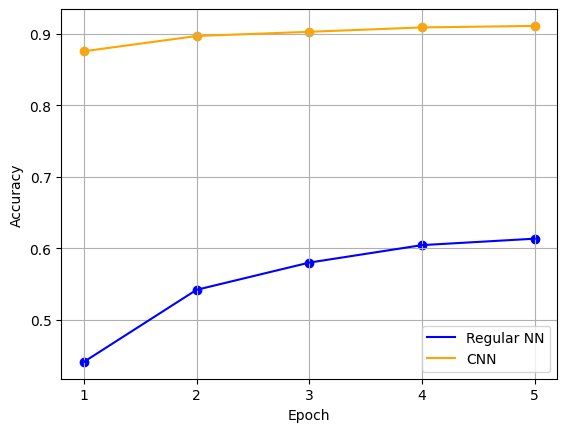

In [24]:
plt.subplot()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
X = np.arange(1, 6)
plt.xticks(X)
plt.plot(X, np.array(test_acc1).T, c="blue", label="Regular NN")
plt.scatter(X, np.array(test_acc1).T, c="blue")
plt.plot(X, np.array(test_acc2).T, c="orange", label="CNN")
plt.scatter(X, np.array(test_acc2).T, c="orange")
plt.legend()
plt.grid()
plt.show()

# Question 4.

**RNN, LSTM, and GRU Comparison for Sequential Data.**

* Create three models: an RNN, an LSTM, and a GRU using a sequential dataset (e.g., a text dataset like IMDB for sentiment analysis or **any time series data**).
* Train each model and evaluate its performance in terms of accuracy, training time, and ability to handle long sequences.
* Provide a comparison report with plots showing each model's loss and accuracy over time.

In [1]:
# Download the dataset

# !wget -O imdb.zip https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

# !unzip imdb.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
# Downloading packages for nltk - a natural language processing library we'll use for tokenization and lemmatization

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anaki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anaki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anaki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Reading the dataset from the downloaded file
df = pd.read_csv('IMDB Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In the dataset we have two columns:
- `review` - movie review texts;
- `sentiment` - a review's sentiment - either `positive` or `negative`. This is the target feature we'll try to predict.

Let's check the target feature's value distribution.

In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

As one can see, the two target classes are of the same size - the data is balanced.

Let's do a rough analysis of the lengths of reviews. To do this, we'll 'tokenize' reviews by splitting them by whitespaces.

In [6]:
df['token_len'] = df['review'].str.split(' ').apply(lambda x: len(x))

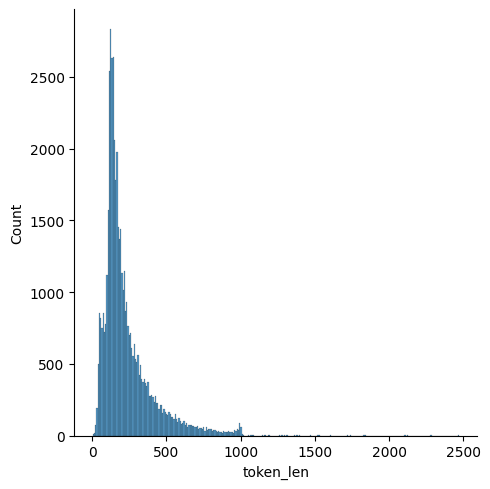

In [7]:
sns.displot(data=df, x='token_len')

As one can see, most reviews are no more than 500 tokens long.

In [8]:
# Turning sentiment into integers via ordinal binary encoding
sentiment_encoding = {'positive': 1, 'negative': 0}
df['sentiment'] = df['sentiment'].map(sentiment_encoding)

df.head()

,review,sentiment,token_len
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


In [9]:
# Splitting data into features & target
X, y = df['review'], df['sentiment']

In [10]:
# Converting all letters to lowercase
X = X.str.lower()

X.head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. <br /><br />the...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object

In [11]:
# Removing HTML tags via regex
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)

In [12]:
# Removing URLs via regex
def remove_url(text):
    pattern=re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

In [13]:
# Removing punctuation using string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('','', string.punctuation))

In [14]:
# Removing stop words (commonly used English words with little value)
def remove_stopwords(tokens):
    return filter(lambda x: x not in stopwords.words('english'), tokens)

In [15]:
# Removing emojis via regex
def remove_emoji(text):
    emoji_pattern=re.compile("["
                             u"\U0001F600-\U0001F64F" #emoticons
                             u"\U0001F300-\U0001F5FF" #symbols, pictograph
                              u"\U0001F680-\U0001F6FF" #transport and map symbol
                              u"\U0001F1E0-\U0001F1FF" # flags(IOS)
                              u"\U00002702-\U000027B0"
                              u"\U00002FC2-\U0001F251"
                             "]+",flags=re.UNICODE)
    return emoji_pattern.sub(r'',text)

In [16]:
# Tokenizing the text via nltk's word_tokenize
def tokenize(text):
    return word_tokenize(text)

In [17]:
# Lemmatizing words in the text (reducing words to their base form)
def lemmatize(text, lemmatizer):
    return lemmatizer.lemmatize(text)

In [18]:
# Unified text processing pipeline function
def process_text(text, lemmatizer=None):
    text = remove_html_tags(text)
    text = remove_url(text)
    text = remove_punc(text)
    text = remove_emoji(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)

    if lemmatizer is not None:
        tokens = list(map(lemmatizer.lemmatize, tokens))

    return list(filter(None, tokens))

In [19]:
wnl = WordNetLemmatizer()

In [20]:
# Turning reviews into lists of tokens
X = X.progress_apply(lambda x: process_text(x, wnl))

X

  0%|          | 0/50000 [00:00<?, ?it/s]

0        [one, reviewer, mentioned, watching, 1, oz, ep...
1        [wonderful, little, production, filming, techn...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, there, family, little, boy, jake, ...
4        [petter, matteis, love, time, money, visually,...
                               ...                        
49995    [thought, movie, right, good, job, wasnt, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [im, going, disagree, previous, comment, side,...
49999    [one, expects, star, trek, movie, high, art, f...
Name: review, Length: 50000, dtype: object

In [21]:
# Counting all words present in reviews
words = X.explode().values.tolist()
counter = collections.Counter(words)

# Creating a dictionary, where values are words, and keys are their integer encodings
# Frequent words are assigned to smaller numbers
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))

# Padding token encoding
padding_id = 0
int2word[padding_id] = '<PAD>'

# A dictionary of encodings for each word
word2int = {word: id for id, word in int2word.items()}

In [22]:
def encode_tokens(token_list, word2int):
    return list(map(word2int.get, token_list))

In [23]:
# Encoding tokens
X = X.progress_apply(encode_tokens, word2int=word2int)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [24]:
X.head()

0    [3, 1020, 944, 66, 414, 3107, 174, 367, 2916, ...
1    [291, 45, 238, 1234, 1610, 15994, 75219, 1356,...
2    [95, 291, 25, 991, 5, 785, 1303, 2214, 1075, 7...
3    [582, 131, 123, 45, 204, 3362, 29, 131, 522, 3...
4    [75224, 30033, 34, 5, 197, 1975, 1250, 2, 33, ...
Name: review, dtype: object

In [25]:
X = X.to_numpy()

In [26]:
# Reducing token lists to a common length
def pad_features(data, padding_id, seq_len=128):
    features = np.full((len(data), seq_len), padding_id, dtype=int)

    for i, row in enumerate(data):
        features[i, :len(row)] = np.array(row)[:seq_len]

    return features

In [27]:
X = pad_features(X, padding_id, seq_len=256)

In [28]:
X.shape

(50000, 256)

In [29]:
y = y.to_numpy()

In [33]:
# Splitting data into training, testing and validation data
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, stratify=y, random_state=random_seed)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=random_seed)

In [36]:
# Creating dataloaders

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 128

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

As per requirements of this task, three RNN models will be trained on given data. These models are:
- a vanilla RNN model;
- an LSTM model;
- a GRU model.

For these models I created a PyTorch module - `RNNModel`. Instead of creating separate modules for each RNN type, I used this class as a common base with customizable architecture. The architecture consists of the following layers:
1. An embedding layer - a trainable embedding lookup table.
2. An RNN layer - recurrent neural network with 2 layers (by default). The type of RNN used at this layer is chosen by specifying the `rnn_type` argument when initializing the model. Options available are: `vanilla` (vanilla RNN), `lstm` (LSTM), and `gru` (GRU).
3. A dropout layer - a layer that randomly zeroes some elements of the input with set probability $p$ (0.3 by default) during training.
4. A linear layer - a linear transformation layer used to transform RNN output into a single value.
5. A sigmoid layer - a layer that uses the sigmoid function to convert the output value to a probability value (a real value between 0 and 1).

In [37]:
class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, embedding_size=256, n_layers=2, dropout=0.25, rnn_type='vanilla'):
        super(RNNModel, self).__init__()

        rnn_types = {
            'vanilla': nn.RNN,
            'lstm': nn.LSTM,
            'gru': nn.GRU
        }

        if rnn_type not in rnn_types:
            raise ValueError(f"architecture must be one of {rnn_types.keys()}")

        self.n_layers = n_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # The RNN layer, chosen from the rnn_types dictionary
        self.rnn = rnn_types[rnn_type](embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        self.embedding = nn.Embedding(input_size, embedding_size) # The embedding layer
        self.dropout = nn.Dropout(0.3) # The dropout layer
        self.fc = nn.Linear(hidden_size, output_size) # The linear layer
        self.sigmoid = nn.Sigmoid() # The sigmoid layer

    def forward(self, x):
        # The network's forward pass
        x = x.long()
        x = self.embedding(x)

        # Here we discard the hidden state
        # This way we reinitialize the hidden state with each new batch
        out, _ = self.rnn(x)
        out = out[:, -1, :]

        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)

        return out

The general approach to training the model is similar to that specified in Question 1. The main differences here are:
- The use of batches - each epoch we train the model on a sequence of groups of features, called batches. Between each batch, the model's hidden state is reset.
- A different optimizer - instead of stochastic gradient descent, I used the Adam algorithm for these models due to its faster convergence.
- A different loss function - because this is a binary classification problem, I used binary cross-entropy (BCE).

In [38]:
# The training 
def train_model(model, epochs, train_loader, val_loader, optimizer, criterion, history, rnn_type_name):
    epoch_loop = tqdm(range(epochs), position=0, desc='Training', leave=True)
    
    train_hist = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    val_loss_min = torch.inf

    for e in epoch_loop:
        # Set the model mode to train
        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(train_loader):
            epoch_loop.set_postfix_str(f'Training batch {id}/{len(train_loader)}')
            feature, target = feature.to(device), target.to(device)

            # Resetting the gradients of model parameters after the previous epoch
            optimizer.zero_grad()

            
            out = model(feature)

            # Calculating accuracy on training data
            preds = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = preds == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            # Calculating the loss (cost) function on training data
            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()

            # Performing loss backpropagation - computing the gradient of the loss function w. r. t. model parameters
            loss.backward()
    
            # Clipping the gradient norm to prevent exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), 5)

            # Adjusting the parameters after the backward pass
            optimizer.step()
            
            del feature, target, preds

        # Saving training loss on each epoch for visualization
        train_hist['train_loss'].append(train_loss / len(train_loader))
        train_hist['train_acc'].append(train_acc / len(train_loader))

        # Set the model mode to evaluation
        model.eval()

        val_loss = 0
        val_acc = 0

        # Calculating the loss function and accuracy on validation data
        with torch.no_grad():
            for id, (feature, target) in enumerate(val_loader):
                epoch_loop.set_postfix_str(f'Validation batch {id}/{len(val_loader)}')
                feature, target = feature.to(device), target.to(device)

                out = model(feature)

                preds = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
                equals = preds == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                del feature, target, preds

            # Saving validation loss on each epoch for visualization
            train_hist['val_loss'].append(val_loss / len(val_loader))
            train_hist['val_acc'].append(val_acc / len(val_loader))

        # Set the model mode to train
        model.train()

        epoch_loop.set_postfix_str(f'Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}')

        epoch_loop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}')
        epoch_loop.update()

        # Saving the model's parameters if its current validation loss is lower than the previous minimum
        if val_loss / len(val_loader) <= val_loss_min:
            torch.save(model.state_dict(), f'./{rnn_type_name}.pt')
            val_loss_min = val_loss / len(val_loader)
        
    history[rnn_type_name] = train_hist

In [43]:
rnn_types = ['vanilla', 'lstm', 'gru']
models = []
history = {}
training_times = {}
epochs = 8
input_size = len(word2int)
output_size = 1

for rnn_type in rnn_types:
    model = RNNModel(input_size, output_size, rnn_type=rnn_type).to(device)
    print(rnn_type)
    print(model)
    print()

    # Initializing the binary cross-entropy loss function criterion
    criterion = nn.BCELoss()
    # Initializing the Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    st = time.time()
    # Training the model
    train_model(model, epochs, train_loader, val_loader, optimizer, criterion, history, rnn_type)
    et = time.time()

    training_time = et - st
    training_times[rnn_type] = training_time
    print(f'{rnn_type} training time: {training_time:.3f} seconds')
    print()

    models.append(model)

vanilla
RNNModel(
  (rnn): RNN(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (embedding): Embedding(211092, 256)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)



Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.712 Train Acc: 0.499 | Val Loss: 0.695 Val Acc: 0.505
Epoch 2/8 | Train Loss: 0.702 Train Acc: 0.507 | Val Loss: 0.698 Val Acc: 0.501
Epoch 3/8 | Train Loss: 0.701 Train Acc: 0.502 | Val Loss: 0.695 Val Acc: 0.505
Epoch 4/8 | Train Loss: 0.698 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.502
Epoch 5/8 | Train Loss: 0.697 Train Acc: 0.503 | Val Loss: 0.708 Val Acc: 0.495
Epoch 6/8 | Train Loss: 0.700 Train Acc: 0.496 | Val Loss: 0.693 Val Acc: 0.515
Epoch 7/8 | Train Loss: 0.697 Train Acc: 0.502 | Val Loss: 0.694 Val Acc: 0.499
Epoch 8/8 | Train Loss: 0.698 Train Acc: 0.503 | Val Loss: 0.700 Val Acc: 0.508
vanilla training time: 1347.325 seconds

lstm
RNNModel(
  (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (embedding): Embedding(211092, 256)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)



Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.694 Train Acc: 0.504 | Val Loss: 0.695 Val Acc: 0.500
Epoch 2/8 | Train Loss: 0.693 Train Acc: 0.502 | Val Loss: 0.694 Val Acc: 0.501
Epoch 3/8 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.693 Val Acc: 0.509
Epoch 4/8 | Train Loss: 0.692 Train Acc: 0.508 | Val Loss: 0.693 Val Acc: 0.510
Epoch 5/8 | Train Loss: 0.682 Train Acc: 0.523 | Val Loss: 0.671 Val Acc: 0.627
Epoch 6/8 | Train Loss: 0.644 Train Acc: 0.585 | Val Loss: 0.660 Val Acc: 0.683
Epoch 7/8 | Train Loss: 0.571 Train Acc: 0.704 | Val Loss: 0.548 Val Acc: 0.745
Epoch 8/8 | Train Loss: 0.419 Train Acc: 0.823 | Val Loss: 0.441 Val Acc: 0.819
lstm training time: 3640.252 seconds

gru
RNNModel(
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (embedding): Embedding(211092, 256)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)



Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.708 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.508
Epoch 2/8 | Train Loss: 0.596 Train Acc: 0.655 | Val Loss: 0.395 Val Acc: 0.827
Epoch 3/8 | Train Loss: 0.297 Train Acc: 0.879 | Val Loss: 0.292 Val Acc: 0.877
Epoch 4/8 | Train Loss: 0.147 Train Acc: 0.948 | Val Loss: 0.333 Val Acc: 0.873
Epoch 5/8 | Train Loss: 0.052 Train Acc: 0.985 | Val Loss: 0.474 Val Acc: 0.872
Epoch 6/8 | Train Loss: 0.029 Train Acc: 0.991 | Val Loss: 0.501 Val Acc: 0.869
Epoch 7/8 | Train Loss: 0.016 Train Acc: 0.995 | Val Loss: 0.618 Val Acc: 0.866
Epoch 8/8 | Train Loss: 0.011 Train Acc: 0.996 | Val Loss: 0.655 Val Acc: 0.865
gru training time: 3425.852 seconds



As one can see, the training time for vanilla RNN is much less than that for LSTM and GRU, and among the latter two GRU is a bit faster to train, which is due to it being a simplified version of LSTM.

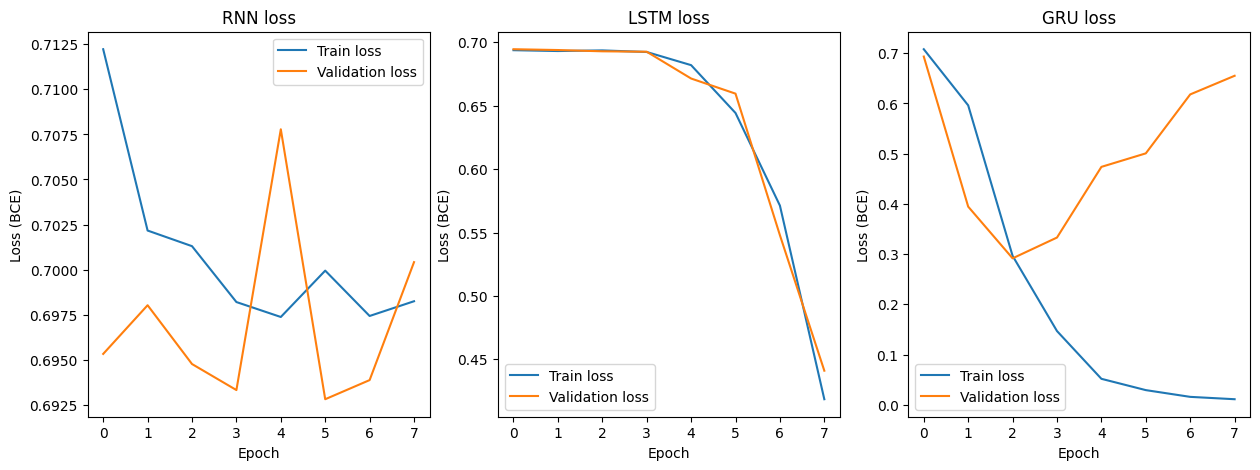

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['vanilla']['train_loss'], label='Train loss')
axes[0].plot(history['vanilla']['val_loss'], label='Validation loss')
axes[0].set(xlabel='Epoch', ylabel='Loss (BCE)')
axes[0].legend()
_ = axes[0].set_title('RNN loss')

axes[1].plot(history['lstm']['train_loss'], label='Train loss')
axes[1].plot(history['lstm']['val_loss'], label='Validation loss')
axes[1].set(xlabel='Epoch', ylabel='Loss (BCE)')
axes[1].legend()
_ = axes[1].set_title('LSTM loss')

axes[2].plot(history['gru']['train_loss'], label='Train loss')
axes[2].plot(history['gru']['val_loss'], label='Validation loss')
axes[2].set(xlabel='Epoch', ylabel='Loss (BCE)')
axes[2].legend()
_ = axes[2].set_title('GRU loss')

Here one can see that RNN has barely been able to train on given data. It's train loss has only dropped by about 0.01, and after that the training process reached a plateau. That might be due to RNN's difficulties with retain long-term dependencies in data.

In contrast, LSTM and GRU show much better results, with both models' BCE loss dropping by more than 0.5. The training process of GRU went noticeably faster, but by epoch 6, it started to show signs of overfitting as validation loss started to grow.

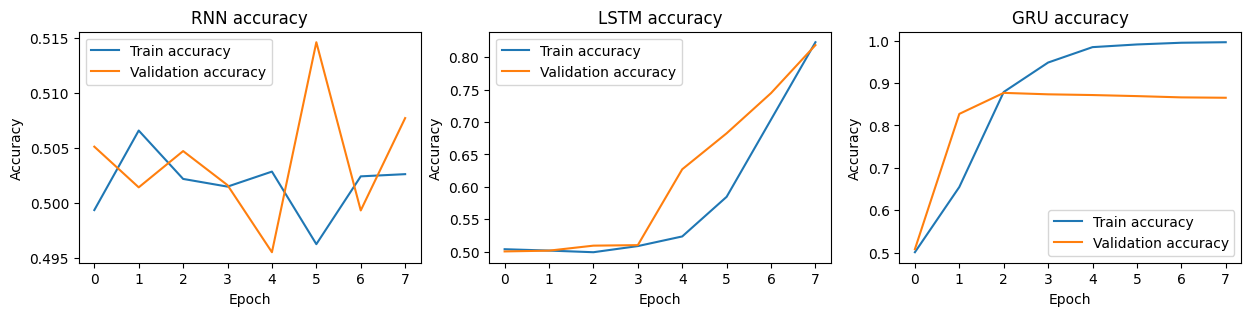

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].plot(history['vanilla']['train_acc'], label='Train accuracy')
axes[0].plot(history['vanilla']['val_acc'], label='Validation accuracy')
axes[0].set(xlabel='Epoch', ylabel='Accuracy')
axes[0].legend()
_ = axes[0].set_title('RNN accuracy')

axes[1].plot(history['lstm']['train_acc'], label='Train accuracy')
axes[1].plot(history['lstm']['val_acc'], label='Validation accuracy')
axes[1].set(xlabel='Epoch', ylabel='Accuracy')
axes[1].legend()
_ = axes[1].set_title('LSTM accuracy')

axes[2].plot(history['gru']['train_acc'], label='Train accuracy')
axes[2].plot(history['gru']['val_acc'], label='Validation accuracy')
axes[2].set(xlabel='Epoch', ylabel='Accuracy')
axes[2].legend()
_ = axes[2].set_title('GRU accuracy')

Accuracy plots show that the vanilla RNN model indeed failed to train, with its accuracy staying around 0.5 throughout the entire training process.

LSTM and GRU, however, managed to reach decent results, with GRU being faster to train once again.

In [46]:
def test_model(model, criterion, test_loader):
    # Set the model mode to evaluation
    model.eval()

    test_loss = 0
    test_acc = 0

    true_list = []
    pred_list = []

    testloop = tqdm(test_loader, leave=True, desc='Inference')
    
    # Calculating loss and accuracy on test data
    with torch.no_grad():
        for feature, target in testloop:
            feature, target = feature.to(device), target.to(device)

            out = model(feature)

            preds = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = preds == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            test_acc += acc.item()

            loss = criterion(out.squeeze(), target.float())
            test_loss += loss.item()

            true_list.extend(target.cpu().numpy())
            pred_list.extend(preds.cpu().numpy())

        print(f'Accuracy: {test_acc/len(test_loader):.3f}, loss: {test_loss/len(test_loader):.3f}')

In [47]:
# Loading best parameters for each model architecture

best_rnn = RNNModel(input_size, output_size, rnn_type='vanilla').to(device)
best_rnn.load_state_dict(torch.load(f'./vanilla.pt', weights_only=True))

best_lstm = RNNModel(input_size, output_size, rnn_type='lstm').to(device)
best_lstm.load_state_dict(torch.load(f'./lstm.pt', weights_only=True))

best_gru = RNNModel(input_size, output_size, rnn_type='gru').to(device)
best_gru.load_state_dict(torch.load(f'./gru.pt', weights_only=True))

<All keys matched successfully>

In [48]:
criterion = nn.BCELoss()

print("RNN test accuracy:")
test_model(best_rnn, criterion, test_loader)

print()

print("LSTM test accuracy:")
test_model(best_lstm, criterion, test_loader)

print()

print("GRU test accuracy:")
test_model(best_gru, criterion, test_loader)

RNN test accuracy:


Inference:   0%|          | 0/78 [00:00<?, ?it/s]

Accuracy: 0.508, loss: 0.693

LSTM test accuracy:


Inference:   0%|          | 0/78 [00:00<?, ?it/s]

Accuracy: 0.823, loss: 0.439

GRU test accuracy:


Inference:   0%|          | 0/78 [00:00<?, ?it/s]

Accuracy: 0.874, loss: 0.297


In conclusion, the best accuracy was achieved by the GRU model, with LSTM falling just 1 percent short. RNN's accuracy is just 0.5, which, in the context of binary classification, is practically equivalent to a model that chooses its prediction randomly.